In [1]:
using Revise
using FUSE
using JLD2
using Plots;
import Metaheuristics: optimize, ECA, SMS_EMOA, SPEA2, TestProblems, pareto_front, Options, convergence

gr();

In [20]:
result_paths = [
    "exploratory/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_A3.5/",
    "exploratory/opt_betaN_cost__Solovev_Kr_flattop48_HTS0.1_A3.5/",
    ]

result_names = ["24hr: cost ","48hr: cost"]

4-element Vector{String}:
 "24hr: cost "
 "48hr: cost"
 "24hr: R0"
 "48hr: R0"

In [21]:
con1 = con2 = con3 = con4 = []
cons = [con1, con2, con3, con4]

for (i, result_path) in enumerate(result_paths)
    
    con = []

    for i in range(1,6)
    
        fname = "result"*string(i)*".jld2"
    
        try
            @load joinpath(result_path, fname) result
            display("Loaded "*fname)
            for c in result.convergence
                con = [con; c]
            end
    
        catch
            display("Could not find "*fname)
        end
    
    end
        
end

In [22]:
min_Pelectric = 200.0 # MW
max_Sn = 1.5
min_fLH = 1.0
max_qpol = 2.75 # GW/m^2
max_ds03 = 1.0

function scatter_gen(
        cons,igens,xlabel,ylabel,
        xrange,yrange,
        fnames,xnames,gnames,
        labels = ["1","2","3"],
        colors = [:red, :orange, :green, :blue, :purple],
        )
    
    s = plot(size=(450, 450), xlabel=xlabel, ylabel=ylabel, xrange=xrange, yrange=yrange) 
    
    for (con, igen, label, color) in zip(cons, igens, labels, colors)

        pop = Dict()
        pf = Dict()
        pfi = []

        # assemble function values
        for (i,fname) in enumerate(fnames)
            str = split(fname, " ")
            pop[str[1]] = [x.f[i] for x in con[igen].population]
            pf[str[1]] = pareto_front(con[igen])[:,i]
        end

        # assemble input values
        for (i,xname) in enumerate(xnames)
            str = split(xname, " ")
            pop[str[1]] = [x.x[i] for x in con[igen].population]
        end

        # assemble constraint values
        for (i,gname) in enumerate(gnames)
            str = split(gname, " ")
            pop[str[1]] =  [x.g[i] for x in con[igen].population]
        end

        # re-scale constraint values
        @. pop["Pnet"] = min_Pelectric/(pop["Pnet"]+1)
        @. pop["Sn"] = max_Sn/(1-pop["Sn"])
        @. pop["accessEC"] = pop["accessEC"] + 1
        @. pop["fLH"] = min_fLH/(pop["fLH"]+1)
        @. pop["qpol"] = max_qpol/(1-pop["qpol"])
        @. pop["ds03"] = max_ds03/(1-pop["ds03"])

        # make array of pareto-optimal indices
        for pf in pf[fnames[1]]
            index = findfirst(isequal(pf), pop[fnames[1]])
            pfi = [pfi;[index]]
        end

        # assemble pareto-optimal input values
        for (i,xname) in enumerate(xnames)
            str = split(xname, " ")
            pf[str[1]] = pop[str[1]][pfi]
        end

        # assemble pareto-optimal constraint values
        for (i,gname) in enumerate(gnames)
            str = split(gname, " ")
            pf[str[1]] = pop[str[1]][pfi]
        end

        ## PLOT

        s1 = scatter!(s, pop[xlabel], pop[ylabel], color=color, label=:none, alpha=0.25)
        s2 = scatter!(s, pf[xlabel], pf[ylabel], color=color, label=label, alpha=0.5)
        
    end
    
    return s
    
end

scatter_gen (generic function with 3 methods)

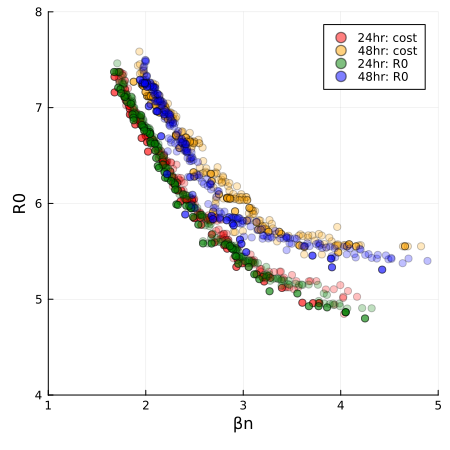

In [23]:
xnames = ["B0 (T)", "R0 (m)", "P0 (MPa)", "Ip (MA)", "fGW", "fGWped", "Paux (MW)"]
gnames = ["Pnet (%)", "Sn (%)", "accessEC (%)", "fLH (%)", "qpol (%)", "ds03 (%)"]
fnames = ["βn", "cost [\$B]"]

xlabel = "βn"
xrange = (1,5)

ylabel = "R0"
yrange = (4,8)

display(scatter_gen(cons,[180,180,180,180],xlabel,ylabel,xrange,yrange,fnames,xnames,gnames,result_names))

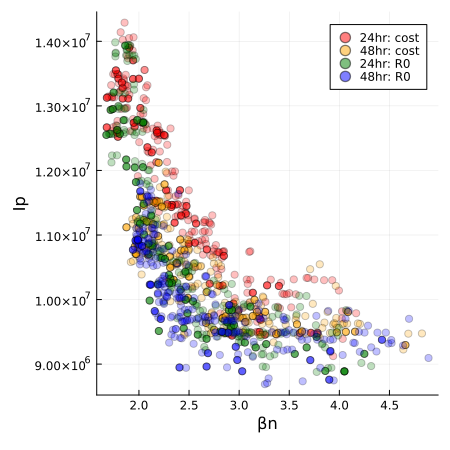

In [32]:
xlabel = "βn"

ylabel = "Ip"

display(scatter_gen(cons,[180,180,180,180],xlabel,ylabel,:missing,:missing,fnames,xnames,gnames,result_names))